In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import os, sys
import tqdm
import matplotlib.patches as mpatches
from PIL import Image as im
import seaborn as sns
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString
import datetime
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import re
import skgstat as skg
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from pykrige.ok import OrdinaryKriging
import matplotlib.patches as patches 
from shapely.geometry import Polygon
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error

In [3]:
fd = "/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/"
df1 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_1.json')
df2 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_2.json')
df3 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_3.json')
df4 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_4.json')
df=pd.concat([df1,df2,df3,df4], axis=0)


In [4]:
fd1 = "/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_here/"
fd2 = "/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_here/athens_streets/"
specific_chunk = pd.read_csv(fd1+'2022-11-07_11_out.csv')

#HERE
ath_str = gpd.read_file(fd2+"athens_streets.shp")
ath_str = ath_str.set_crs('EPSG:4326', allow_override=True)

In [151]:
ath_str = gpd.read_file(fd2+"athens_streets.shp")
ath_str = ath_str.set_crs('EPSG:4326', allow_override=True)
ath_str.to_crs(32234, inplace=True)
#ath_str.rename(columns={"geometry":"geometry_sec"}, inplace=True)

In [107]:
detectors = gpd.read_file(fd+"detectors.shp")
detectors = detectors.set_crs('EPSG:32234', allow_override=True)
# detectors = detectors.to_crs(epsg=4326)

sections = gpd.read_file(fd+"sections.shp")
sections = sections.set_crs('EPSG:32234', allow_override=True)
sections.rename(columns={"geometry":"geometry_sec"}, inplace=True)
# sections = sections.to_crs(epsg=4326)

In [108]:
mod_fun=pd.read_csv(fd+'det_mod_func_cls.csv')

In [109]:
sections["section_id"]=sections["id"]
# sections.head()


In [110]:
def get_length(line_string):
    line = LineString(line_string)
    return line.length

# LDD_df[['countedcars']] = LDD_df[['countedcars']].fillna(0)

In [111]:
###Equipped networkkkkkkk

In [112]:
eq_network1=pd.merge(detectors, sections[["section_id", 'func_class','geometry_sec']], on='section_id')
tl_network1=pd.merge( detectors,sections[["section_id", 'func_class','geometry_sec']], on='section_id',how='outer')


In [113]:
eq_network=pd.merge(eq_network1,mod_fun, on='name')
tl_network=pd.merge(tl_network1,mod_fun, on='name',how='outer')

In [123]:
len(tl_network['FUNC_CLASS'])

2654

In [124]:
len(detectors)

264

In [116]:
no_det_links = tl_network.loc[~tl_network['section_id'].isin(detectors['section_id']), ['section_id', 'FUNC_CLASS', 'geometry_sec']]

In [42]:
#class_specific network
eqq_network = eq_network.groupby('FUNC_CLASS', group_keys=False).apply(lambda x: x.sample(frac=1.0, random_state=0))
neq_network = eq_network.drop(eqq_network.index)

In [167]:
ath_str.head()

,LINK_ID,ST_NAME,FEAT_ID,ST_LANGCD,NUM_STNMES,ST_NM_PREF,ST_TYP_BEF,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,...,CARPOOLRD,PHYS_LANES,VER_TRANS,PUB_ACCESS,LOW_MBLTY,PRIORITYRD,SPD_LM_SRC,EXPAND_INC,TRANS_AREA,geometry
0,573243545,None,0,None,0,None,None,None,None,None,...,N,0,N,Y,3,N,None,None,N,"LINESTRING (736471.787 4209160.982, 736492.457..."
1,573243546,ΚΟΛΩΝΟΥ,1470816414,GRE,1,None,None,ΚΟΛΩΝΟΥ,None,None,...,N,0,N,Y,3,N,None,None,N,"LINESTRING (736471.787 4209160.982, 736458.421..."
2,573243547,ΓΡΕΒΕΝΩΝ,1470809215,GRE,1,None,None,ΓΡΕΒΕΝΩΝ,None,None,...,N,0,N,Y,3,N,None,None,N,"LINESTRING (736341.094 4209151.645, 736341.169..."
3,573243548,ΣΤΡΥΜΩΝΟΣ,1470809537,GRE,1,None,None,ΣΤΡΥΜΩΝΟΣ,None,None,...,N,0,N,Y,3,N,None,None,N,"LINESTRING (736341.094 4209151.645, 736293.970..."
4,573243551,ΓΟΥΜΕΝΙΤΣΗΣ,1470786244,GRE,1,None,None,ΓΟΥΜΕΝΙΤΣΗΣ,None,None,...,N,0,N,Y,3,N,None,None,N,"LINESTRING (736406.018 4209155.746, 736419.009..."


In [ ]:
# Make sure geometry_sec is a GeoSeries with correct CRS
eqq_network = eqq_network.set_geometry('geometry_sec')
eqq_network = eqq_network.set_crs('EPSG:32234', allow_override=True)

# Calculate lengths
eqq_network['length_m'] = eqq_network['geometry_sec'].length

# Group by FUNC_CLASS and sum
total_length_by_class = eqq_network.groupby('FUNC_CLASS')['length_m'].sum()

# Display result in kilometers
total_length_by_class_km = total_length_by_class / 1000
print(total_length_by_class_km)


In [43]:
eqq_network['deviceid']=eqq_network['name']
eqq_network['lane']=abs(eqq_network['from_lane']-eqq_network['to_lane'])

neq_network['deviceid']=neq_network['name']
neq_network['lane']=abs(neq_network['from_lane']-neq_network['to_lane'])


In [44]:
def g(df):
    df['countedcars'] = np.where(df['lane']==0, df['countedcars'], df['countedcars'] / df['lane'])
    return df

In [47]:

LDD_eq=df.merge(eqq_network).drop(columns=['road_info', 'road_name','eid','id','length','from_lane','to_lane','name'])
LDD_eq = g(LDD_eq.copy())
LDD_eq = gpd.GeoDataFrame(LDD_eq, geometry=LDD_eq['geometry_sec'])


LDD_neq=df.merge(neq_network).drop(columns=['road_info', 'road_name','eid','id','length','from_lane','to_lane','name'])
LDD_neq = g(LDD_neq.copy())
LDD_neq = gpd.GeoDataFrame(LDD_neq, geometry=LDD_neq['geometry_sec'])


In [48]:
LDD_eq['appprocesstime'] = pd.to_datetime(LDD_eq['appprocesstime'])
LDD_eq['DATE-TIME'] = LDD_eq['appprocesstime'].dt.tz_localize(None)

LDD_neq['appprocesstime'] = pd.to_datetime(LDD_neq['appprocesstime'])
LDD_neq['DATE-TIME'] = LDD_neq['appprocesstime'].dt.tz_localize(None)

In [422]:
LDD_eq

,appprocesstime,average_speed,countedcars,deviceid,section_id,position,geometry,func_class,geometry_sec,Unnamed: 0,FUNC_CLASS,lane,DATE-TIME
0,2022-08-03 23:00:00+00:00,46.073171,318.0,MS229,555534.0,35.09,"LINESTRING (739883.861 4205592.081, 739835.434...",4,"LINESTRING (739883.861 4205592.081, 739835.434...",558,1,2.0,2022-08-03 23:00:00
1,2022-08-03 22:00:00+00:00,45.804878,366.5,MS229,555534.0,35.09,"LINESTRING (739883.861 4205592.081, 739835.434...",4,"LINESTRING (739883.861 4205592.081, 739835.434...",558,1,2.0,2022-08-03 22:00:00
2,2022-08-03 21:00:00+00:00,44.170732,511.5,MS229,555534.0,35.09,"LINESTRING (739883.861 4205592.081, 739835.434...",4,"LINESTRING (739883.861 4205592.081, 739835.434...",558,1,2.0,2022-08-03 21:00:00
3,2022-08-03 20:00:00+00:00,44.390244,586.5,MS229,555534.0,35.09,"LINESTRING (739883.861 4205592.081, 739835.434...",4,"LINESTRING (739883.861 4205592.081, 739835.434...",558,1,2.0,2022-08-03 20:00:00
4,2022-08-03 19:00:00+00:00,41.707317,620.0,MS229,555534.0,35.09,"LINESTRING (739883.861 4205592.081, 739835.434...",4,"LINESTRING (739883.861 4205592.081, 739835.434...",558,1,2.0,2022-08-03 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140358,2023-05-04 04:00:00+00:00,48.700000,166.0,MS636,372737.0,37.09,"LINESTRING (737881.295 4207870.615, 737812.436...",3,"LINESTRING (737881.295 4207870.615, 737812.436...",1050,2,2.0,2023-05-04 04:00:00
140359,2023-05-04 03:00:00+00:00,48.925000,118.5,MS636,372737.0,37.09,"LINESTRING (737881.295 4207870.615, 737812.436...",3,"LINESTRING (737881.295 4207870.615, 737812.436...",1050,2,2.0,2023-05-04 03:00:00
140360,2023-05-04 02:00:00+00:00,49.400000,175.5,MS636,372737.0,37.09,"LINESTRING (737881.295 4207870.615, 737812.436...",3,"LINESTRING (737881.295 4207870.615, 737812.436...",1050,2,2.0,2023-05-04 02:00:00
140361,2023-05-04 01:00:00+00:00,49.625000,274.0,MS636,372737.0,37.09,"LINESTRING (737881.295 4207870.615, 737812.436...",3,"LINESTRING (737881.295 4207870.615, 737812.436...",1050,2,2.0,2023-05-04 01:00:00


In [229]:
#HERE_classifification
# Initialize the time range
LDD_eq.set_index('DATE-TIME', inplace=True)
LDD_neq.set_index('DATE-TIME', inplace=True)
origin = pd.to_datetime('2022-11-07 00:00:00')
end_time = pd.to_datetime('2022-11-11 23:00:00')
time_range = pd.date_range(start=origin, end=end_time, freq='H')

LDD_link1=LDD_eq[LDD_eq['FUNC_CLASS']==1]
LDD_link2=LDD_eq[LDD_eq['FUNC_CLASS']==2]
LDD_link3=LDD_eq[LDD_eq['FUNC_CLASS']==3]
LDD_neq_1=LDD_neq[LDD_neq['FUNC_CLASS']==1]
LDD_neq_2=LDD_neq[LDD_neq['FUNC_CLASS']==2]
LDD_neq_3=LDD_neq[LDD_neq['FUNC_CLASS']==3]

results = []
# Iterate through each hour in the time range
for current_time in time_range:
    # Filter data for the current time window
    eq_resampled_1 = LDD_link1[(LDD_link1.index >= current_time) & (LDD_link1.index < current_time + timedelta(hours=1))]
    eq_resampled_2 = LDD_link2[(LDD_link2.index >= current_time) & (LDD_link2.index < current_time + timedelta(hours=1))]
    eq_resampled_3 = LDD_link3[(LDD_link3.index >= current_time) & (LDD_link3.index < current_time + timedelta(hours=1))]
    eq_resampled_1 = eq_resampled_1[eq_resampled_1['average_speed'] > 0]
    eq_resampled_2 = eq_resampled_2[eq_resampled_2['average_speed'] > 0]
    eq_resampled_3 = eq_resampled_3[eq_resampled_3['average_speed'] > 0]
    
    eq_resampled_1 = eq_resampled_1.reset_index()
    eq_resampled_2 = eq_resampled_2.reset_index()
    eq_resampled_3 = eq_resampled_3.reset_index()
    
    neq_resampled_1 = LDD_neq_1[(LDD_neq_1.index >= current_time) & (LDD_neq_1.index < current_time + timedelta(hours=1))]
    neq_resampled_2 = LDD_neq_2[(LDD_neq_2.index >= current_time) & (LDD_neq_2.index < current_time + timedelta(hours=1))]
    neq_resampled_3 = LDD_neq_3[(LDD_neq_3.index >= current_time) & (LDD_neq_3.index < current_time + timedelta(hours=1))]
    neq_resampled_1 = neq_resampled_1[neq_resampled_1['average_speed'] > 0]
    neq_resampled_2 = neq_resampled_2[neq_resampled_2['average_speed'] > 0]
    neq_resampled_3 = neq_resampled_3[neq_resampled_3['average_speed'] > 0]
    
    neq_resampled_1 = neq_resampled_1.reset_index()
    neq_resampled_2 = neq_resampled_2.reset_index()
    neq_resampled_3 = neq_resampled_3.reset_index()

    #class-1 and eq
    if len(eq_resampled_1) > 0:
    #     E_l3_eq = sum((df_resampled_3['geometry_sec'].length)/1000)/len(df_resampled_3['countedcars'])
        E_q1_eq = sum(eq_resampled_1['countedcars']*eq_resampled_1['geometry_sec'].length/1000)/sum(eq_resampled_1['geometry_sec'].length/1000)
        l1_eq = sum((eq_resampled_1['geometry_sec'].length)/1000)
        q1l1_eq = sum(eq_resampled_1['countedcars']*eq_resampled_1['geometry_sec'].length/1000)
        cov_q1_l1_eq = (eq_resampled_1['countedcars']).cov(eq_resampled_1['geometry_sec'].length/1000)
        m_1=len(eq_resampled_1['countedcars'])
        k1l1_eq=sum((eq_resampled_1['countedcars']*eq_resampled_1['geometry_sec'].length/1000)/eq_resampled_1['average_speed'])
    
    #class-2 and eq
    if len(eq_resampled_2) > 0:
        E_q2_eq = sum(eq_resampled_2['countedcars']*eq_resampled_2['geometry_sec'].length/1000)/sum(eq_resampled_2['geometry_sec'].length/1000)
        l2_eq = sum((eq_resampled_2['geometry_sec'].length)/1000)
        q2l2_eq = sum(eq_resampled_2['countedcars']*eq_resampled_2['geometry_sec'].length/1000)
        cov_q2_l2_eq = (eq_resampled_2['countedcars']).cov(eq_resampled_2['geometry_sec'].length/1000)
        m_2=len(eq_resampled_2['countedcars'])
        k2l2_eq=sum((eq_resampled_2['countedcars']*eq_resampled_2['geometry_sec'].length/1000)/eq_resampled_2['average_speed'])
        
      #class-3 and eq
    if len(eq_resampled_3) > 0:
        E_q3_eq = sum(eq_resampled_3['countedcars']*eq_resampled_3['geometry_sec'].length/1000)/sum(eq_resampled_3['geometry_sec'].length/1000)
        l3_eq = sum((eq_resampled_3['geometry_sec'].length)/1000)
        q3l3_eq = sum(eq_resampled_3['countedcars']*eq_resampled_3['geometry_sec'].length/1000)
        cov_q3_l3_eq = (eq_resampled_3['countedcars']).cov(eq_resampled_3['geometry_sec'].length/1000)
        m_3=len(eq_resampled_3['countedcars'])
        k3l3_eq=sum((eq_resampled_3['countedcars']*eq_resampled_3['geometry_sec'].length/1000)/eq_resampled_3['average_speed'])

    #class-1 and neq
    if len(neq_resampled_1) > 0:
        E_q1_neq = sum(neq_resampled_1['countedcars']*neq_resampled_1['geometry_sec'].length/1000)/sum(neq_resampled_1['geometry_sec'].length/1000)
        l1_neq = sum((neq_resampled_1['geometry_sec'].length)/1000)
        q1l1_neq = sum(neq_resampled_1['countedcars']*neq_resampled_1['geometry_sec'].length/1000)
        cov_q1_l1_neq = (neq_resampled_1['countedcars']).cov(neq_resampled_1['geometry_sec'].length/1000)
        n_1=len(neq_resampled_1['countedcars'])
        k1l1_neq=sum((neq_resampled_1['countedcars']*neq_resampled_1['geometry_sec'].length/1000)/neq_resampled_1['average_speed'])
        
    #class-2 and neq
    if len(neq_resampled_2) > 0:
        E_q2_neq = sum(neq_resampled_2['countedcars']*neq_resampled_2['geometry_sec'].length/1000)/sum(neq_resampled_2['geometry_sec'].length/1000)
        l2_neq = sum((neq_resampled_2['geometry_sec'].length)/1000)
        q2l2_neq = sum(neq_resampled_2['countedcars']*neq_resampled_2['geometry_sec'].length/1000)
        cov_q2_l2_neq = (neq_resampled_2['countedcars']).cov(neq_resampled_2['geometry_sec'].length/1000)
        n_2=len(neq_resampled_2['countedcars'])
        k2l2_neq=sum((neq_resampled_2['countedcars']*neq_resampled_2['geometry_sec'].length/1000)/neq_resampled_2['average_speed'])
        
    #class-3 and neq
    if len(neq_resampled_3) > 0:
        E_q3_neq = sum(neq_resampled_3['countedcars']*neq_resampled_3['geometry_sec'].length/1000)/sum(neq_resampled_3['geometry_sec'].length/1000)
        l3_neq = sum((neq_resampled_3['geometry_sec'].length)/1000)
        q3l3_neq = sum(neq_resampled_3['countedcars']*neq_resampled_3['geometry_sec'].length/1000)
        cov_q3_l3_neq = (neq_resampled_3['countedcars']).cov(neq_resampled_3['geometry_sec'].length/1000)
        n_3=len(neq_resampled_3['countedcars'])
        k3l3_neq=sum((neq_resampled_3['countedcars']*neq_resampled_3['geometry_sec'].length/1000)/neq_resampled_3['average_speed'])
    
    
    ##flow estimated and actual 
    
    act_flow = (q1l1_eq+q2l2_eq+q3l3_eq+q1l1_neq+q3l3_neq+q2l2_neq)/(l3_eq+l3_neq+l2_eq+l2_neq+l1_eq+l1_neq)
#     est_flow= (q3l3_eq+q2l2_eq+q1l1_eq+(q3l3_eq *(l3_neq/l3_eq)+(n_3)*cov_q3_l3_eq)+(q2l2_eq *(l2_neq/l2_eq)+(n_2)*cov_q2_l2_eq)+(q1l1_eq *(l1_neq/l1_eq)+(n_1)*cov_q1_l1_eq))/(l3_eq+l3_neq+l2_eq+l2_neq+l1_eq+l1_neq)
    act_den = (k1l1_eq+k2l2_eq+k3l3_eq+k1l1_neq+k3l3_neq+k2l2_neq)/(l3_eq+l3_neq+l2_eq+l2_neq+l1_eq+l1_neq)
    est_den = (k3l3_eq+k2l2_eq+k1l1_eq+(k3l3_eq *(l3_neq/l3_eq))+(k2l2_eq *(l2_neq/l2_eq))+(k1l1_eq *(l1_neq/l1_eq)))/(l3_eq+l3_neq+l2_eq+l2_neq+l1_eq+l1_neq)
    est_flow= (q3l3_eq+q2l2_eq+q1l1_eq+(q3l3_eq *(l3_neq/l3_eq))+(q2l2_eq *(l2_neq/l2_eq))+(q1l1_eq *(l1_neq/l1_eq)))/(l3_eq+l3_neq+l2_eq+l2_neq+l1_eq+l1_neq)
    results.append({
        'datetime': current_time,
        'T_l1q1_eq': q1l1_eq,
        'T_l1_eq': l1_eq,
        'cov_l1q1_eq': cov_q1_l1_eq,
        'E_q1_eq': E_q1_eq,

        'T_l1_nq': l1_neq,
        'cov_l1q1_nq': cov_q1_l1_neq,
        'E_q1_nq': E_q1_neq,

        'T_l2q2_eq': q2l2_eq,
        'T_l2_eq': l2_eq,
        'cov_l2q2_eq': cov_q2_l2_eq,
        'E_q2_eq': E_q2_eq,

        'T_l2_nq': l2_neq,
        'cov_l2q2_nq': cov_q2_l2_neq,
        'E_q2_nq': E_q2_neq,
        
        'T_l3q3_eq': q3l3_eq,
        'T_l3_eq': l3_eq,
        'cov_l3q3_eq': cov_q3_l3_eq,
        'E_q3_eq': E_q3_eq,

        'T_l3_nq': l3_neq,
        'cov_l3q3_nq': cov_q3_l3_neq,
        'E_q3_nq': E_q3_neq,

        'net_act_flw':act_flow,
        'net_est_flow':est_flow,
        'net_act_den':act_den,
        'net_est_den':est_den
        
    })

# Convert results into a DataFrame
eq_network_test1 = pd.DataFrame(results)


In [230]:
eq_network_test1.to_csv(fd2+'eq_network_hie_HERE_1_30_.csv')

In [5]:
###without covirance term
test_ath_10=pd.read_csv(fd2+'eq_network_hie_ath_10.csv')
test_ath_20=pd.read_csv(fd2+'eq_network_hie_ath_20.csv')
test_ath_30=pd.read_csv(fd2+'eq_network_hie_ath_30.csv')

test_here_10=pd.read_csv(fd2+'eq_network_hie_HERE_1_10.csv')
test_here_20=pd.read_csv(fd2+'eq_network_hie_HERE_1_20.csv')
test_here_30=pd.read_csv(fd2+'eq_network_hie_HERE_1_30.csv')

test1=pd.read_csv(fd2+'eq_network_nonhier_10.csv')
test2=pd.read_csv(fd2+'eq_network_nonhier_20.csv')
test3=pd.read_csv(fd2+'eq_network_nonhier_30.csv')


vario_10=pd.read_csv(fd2+'variogram_10_HERE.csv')
vario_20=pd.read_csv(fd2+'variogram_20_HERE.csv')
vario_30=pd.read_csv(fd2+'variogram_30_HERE.csv')

vario_10_new=pd.merge(test_here_10,vario_10, on='datetime')
vario_20_new=pd.merge(test_here_20,vario_20, on='datetime')
vario_30_new=pd.merge(test_here_30,vario_30, on='datetime')


In [10]:
vario_10_new.head()

,Unnamed: 0_x,datetime,T_l1q1_eq,T_l1_eq,cov_l1q1_eq,E_q1_eq,T_l1_nq,cov_l1q1_nq,E_q1_nq,T_l2q2_eq,...,E_q3_eq,T_l3_nq,cov_l3q3_nq,E_q3_nq,net_act_flw,net_est_flow,Unnamed: 0_y,q_net,mean,std
0,0,2022-11-07 00:00:00,183.239187,0.587991,2.917606,311.635971,4.158169,-0.203274,331.636385,586.774554,...,295.227801,4.371597,-1.661682,268.215830,322.462292,357.550496,0,136.874866,345.767272,190.536260
1,1,2022-11-07 01:00:00,104.780416,0.587991,0.802903,178.200675,4.158169,0.742555,212.365234,360.902943,...,200.125527,4.371597,-0.853756,179.299855,206.867385,221.196001,1,135.449772,212.876446,128.561416
2,2,2022-11-07 02:00:00,58.081840,0.587991,-0.398338,98.780130,4.158169,0.280536,128.951653,227.689691,...,152.553892,4.371597,-1.578277,114.737980,129.554059,142.651477,2,93.229995,138.754856,92.000581
3,3,2022-11-07 03:00:00,45.654897,0.587991,0.273524,77.645554,4.158169,0.041425,85.598524,177.040843,...,121.719157,4.371597,-0.755296,80.172042,94.341982,111.860512,3,47.799797,103.769552,64.884858
4,4,2022-11-07 04:00:00,39.508925,0.587991,-0.215323,67.193062,4.158169,-0.182602,88.315025,201.611935,...,167.154444,4.371597,-0.376005,97.688414,108.208660,129.241481,4,50.430546,110.782966,65.972696


In [7]:
###with covirance term
test_ath_05=pd.read_csv(fd2+'eq_network_hie_ath_05_cov.csv')
test_ath_10=pd.read_csv(fd2+'eq_network_hie_ath_10.csv')
test_ath_20=pd.read_csv(fd2+'eq_network_hie_ath_20.csv')
test_ath_30=pd.read_csv(fd2+'eq_network_hie_ath_30.csv')

#test_here_05=pd.read_csv(fd2+'eq_network_hie_HERE_1_05_cov.csv')
#test_here_10=pd.read_csv(fd2+'eq_network_hie_HERE_1_10_cov.csv')
#test_here_20=pd.read_csv(fd2+'eq_network_hie_HERE_1_20_cov.csv')
#test_here_30=pd.read_csv(fd2+'eq_network_hie_HERE_1_30_cov.csv')

#test4=pd.read_csv(fd2+'eq_network_nonhier_05_cov.csv')
#test1=pd.read_csv(fd2+'eq_network_nonhier_10_cov.csv')
#test2=pd.read_csv(fd2+'eq_network_nonhier_20_cov.csv')
#test3=pd.read_csv(fd2+'eq_network_nonhier_30_cov.csv')


#test_ath_05=pd.read_csv(fd2+'eq_network_hie_ath_05_qk.csv')
#test_ath_10=pd.read_csv(fd2+'eq_network_hie_ath_10_qk.csv')
#test_ath_20=pd.read_csv(fd2+'eq_network_hie_ath_20_qk.csv')
#test_ath_30=pd.read_csv(fd2+'eq_network_hie_ath_30_qk.csv')

test_here_05=pd.read_csv(fd2+'eq_network_hie_HERE_1_05_.csv')
test_here_10=pd.read_csv(fd2+'eq_network_hie_HERE_1_10_.csv')
test_here_20=pd.read_csv(fd2+'eq_network_hie_HERE_1_20_.csv')
test_here_30=pd.read_csv(fd2+'eq_network_hie_HERE_1_30_.csv')

test4=pd.read_csv(fd2+'eq_network_nonhier_05_qk.csv')
test1=pd.read_csv(fd2+'eq_network_nonhier_10_qk.csv')
test2=pd.read_csv(fd2+'eq_network_nonhier_20_qk.csv')
test3=pd.read_csv(fd2+'eq_network_nonhier_30_qk.csv')

vario_10_new=pd.merge(test_here_10,vario_10, on='datetime')
vario_20_new=pd.merge(test_here_20,vario_20, on='datetime')
vario_30_new=pd.merge(test_here_30,vario_30, on='datetime')


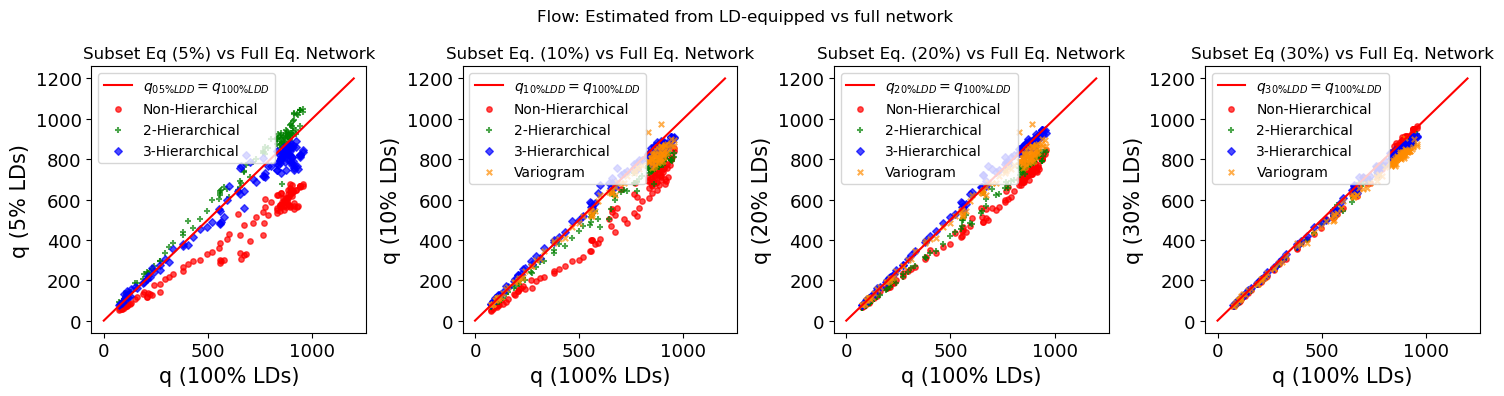

In [65]:
x = np.linspace(0, 1200, 100)
y=x

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))  # Adjust figsize as per your needs

fig.suptitle('Flow: Estimated from LD-equipped vs full network')

# Plot for ax4
ax1.plot(x, y, label='$q_{05\% LDD}=q_{100\% LDD}$', color='Red')

ax1.scatter( test_here_05['net_act_flw'],test4['est_fl'], marker='o',c='r',s=15, label='Non-Hierarchical',alpha=0.7)
ax1.scatter( test_here_05['net_act_flw'],test_ath_05['net_est_flow'], marker='+',c='g',s=15, label='2-Hierarchical',alpha=0.7)
ax1.scatter( test_here_05['net_act_flw'],test_here_05['net_est_flow'], marker='D',c='blue',s=15, label='3-Hierarchical',alpha=0.7)
# ax3.scatter( vario_30_new['net_act_flw'],vario_30_new['mean'], marker='x',c='orange', label='Variogram')

ax1.set_title('Subset Eq (5%) vs Full Eq. Network') 
ax1.set_ylabel('q (5% LDs)',fontsize=15)    
ax1.set_xlabel('q (100% LDs)',fontsize=15)
ax1.tick_params(axis='y', labelsize=13) 
ax1.tick_params(axis='x', labelsize=13)
ax1.legend(fontsize=10)


# Plot for ax1
ax2.plot(x, y, label='$q_{10\% LDD}=q_{100\% LDD}$', color='Red')
ax2.scatter( test_here_10['net_act_flw'],test1['est_fl'], marker='o',c='r', s=15,label='Non-Hierarchical',alpha=0.7)
ax2.scatter( test_here_10['net_act_flw'],test_ath_10['net_est_flow'], marker='+',c='g',s=15, label='2-Hierarchical',alpha=0.7)
ax2.scatter( test_here_10['net_act_flw'],test_here_10['net_est_flow'], marker='D',c='blue',s=15, label='3-Hierarchical',alpha=0.7)
ax2.scatter( vario_10_new['net_act_flw'],vario_10_new['mean'], marker='x',c='darkorange',s=15, label='Variogram',alpha=0.7)

ax2.set_title('Subset Eq. (10%) vs Full Eq. Network') 
ax2.set_ylabel('q (10% LDs)',fontsize=15)    
ax2.set_xlabel('q (100% LDs)',fontsize=15)
ax2.tick_params(axis='y', labelsize=13) 
ax2.tick_params(axis='x', labelsize=13)
ax2.legend(fontsize=10)

# Plot for ax1
ax3.plot(x, y, label='$q_{20\% LDD}=q_{100\% LDD}$', color='Red')

ax3.scatter( test_here_20['net_act_flw'],test2['est_fl'], marker='o',c='r',s=15, label='Non-Hierarchical',alpha=0.7)
ax3.scatter( test_here_20['net_act_flw'],test_ath_20['net_est_flow'], marker='+',c='g',s=15, label='2-Hierarchical',alpha=0.7)
ax3.scatter( test_here_20['net_act_flw'],test_here_20['net_est_flow'], marker='D',c='blue',s=15, label='3-Hierarchical',alpha=0.7)
ax3.scatter( vario_20_new['net_act_flw'],vario_20_new['mean'], marker='x',c='darkorange',s=15, label='Variogram',alpha=0.7)

ax3.set_title('Subset Eq. (20%) vs Full Eq. Network') 
ax3.set_ylabel('q (20% LDs)',fontsize=15)    
ax3.set_xlabel('q (100% LDs)',fontsize=15)  
ax3.tick_params(axis='y', labelsize=13) 
ax3.tick_params(axis='x', labelsize=13)
ax3.legend(fontsize=10)

# Plot for ax1
ax4.plot(x, y, label='$q_{30\% LDD}=q_{100\% LDD}$', color='Red')

ax4.scatter( test_here_30['net_act_flw'],test3['est_fl'], marker='o',c='r',s=15, label='Non-Hierarchical',alpha=0.7)
ax4.scatter( test_here_30['net_act_flw'],test_ath_30['net_est_flow'], marker='+',c='g',s=15, label='2-Hierarchical',alpha=0.7)
ax4.scatter( test_here_30['net_act_flw'],test_here_30['net_est_flow'], marker='D',c='blue',s=15, label='3-Hierarchical',alpha=0.7)
ax4.scatter( vario_30_new['net_act_flw'],vario_30_new['mean'], marker='x',c='darkorange',s=15, label='Variogram',alpha=0.7)

ax4.set_title('Subset Eq (30%) vs Full Eq. Network') 
ax4.set_ylabel('q (30% LDs)',fontsize=15)    
ax4.set_xlabel('q (100% LDs)',fontsize=15)
ax4.tick_params(axis='y', labelsize=13) 
ax4.tick_params(axis='x', labelsize=13)
ax4.legend(loc='upper left', fontsize=10)




# Display the plot
plt.tight_layout()
plt.show()

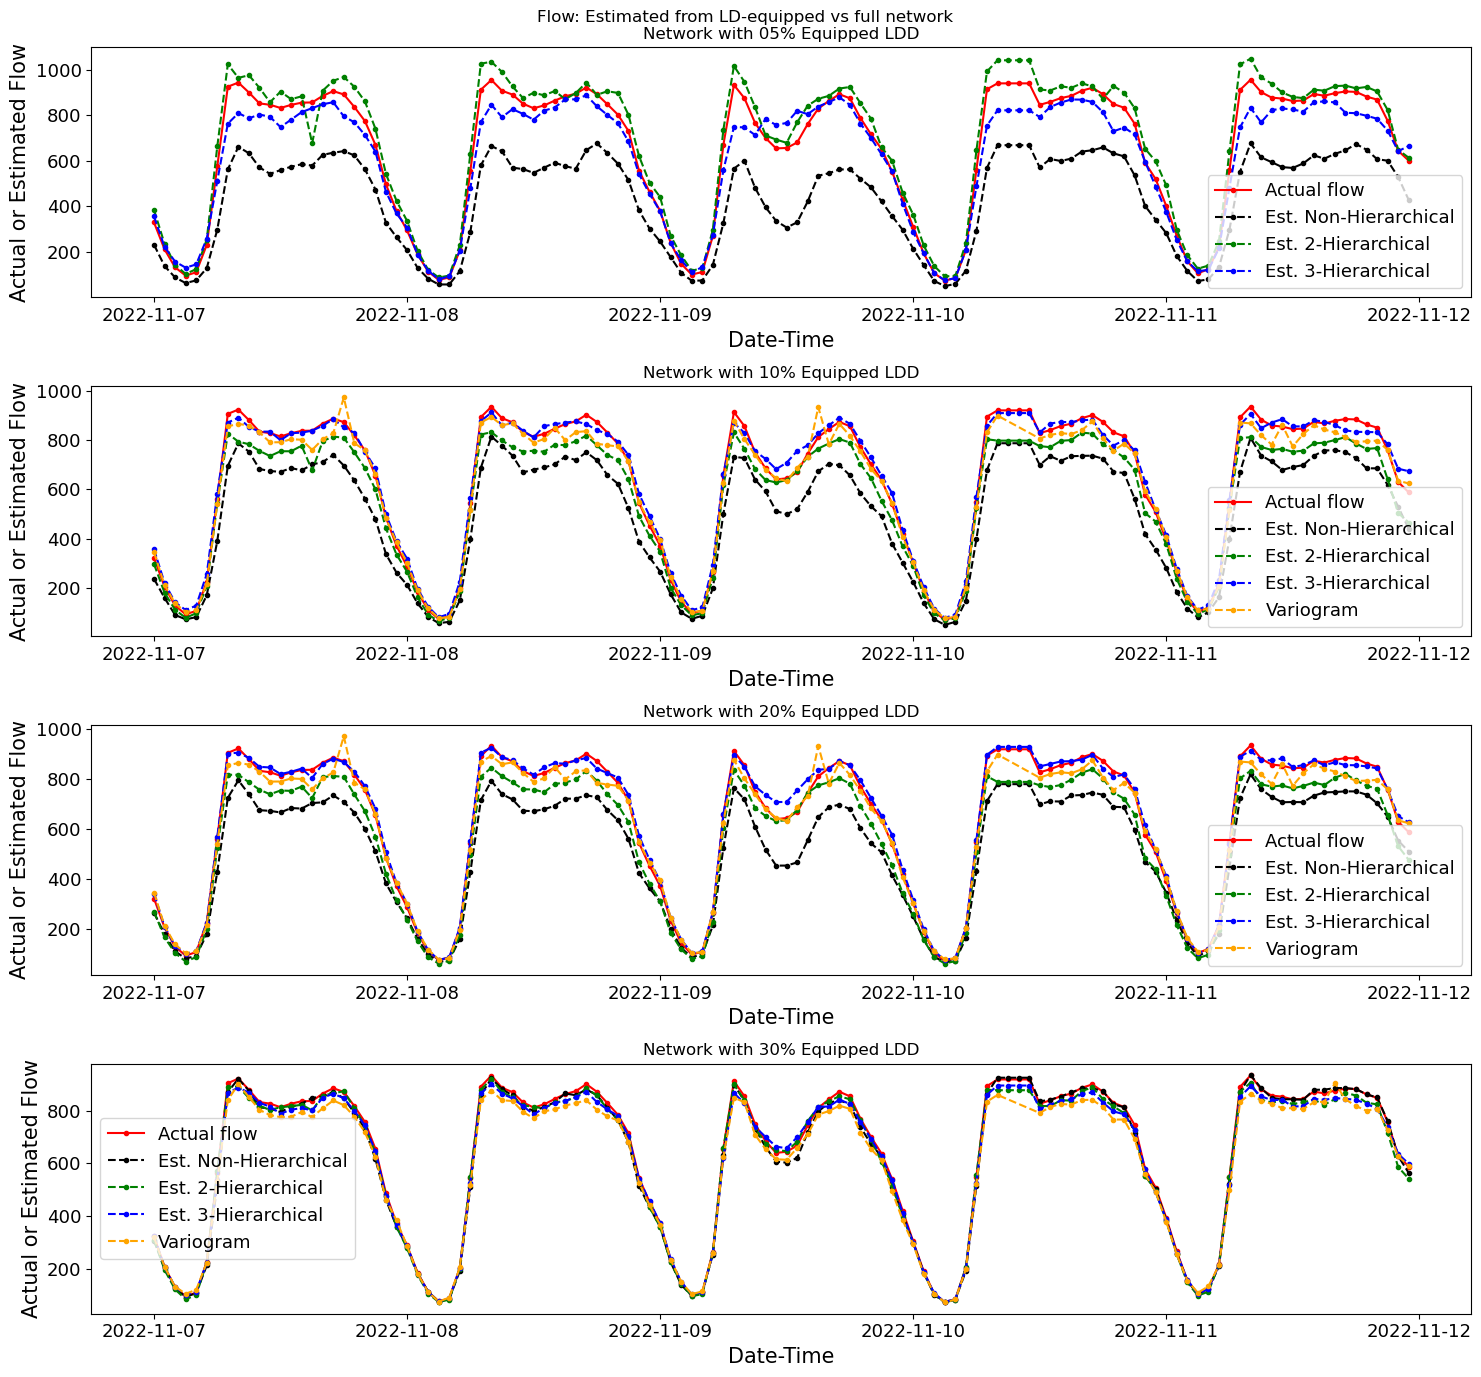

In [11]:
x = np.linspace(0, 1200, 100)
y=x

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 14))  # Adjust figsize as per your needs

fig.suptitle('Flow: Estimated from LD-equipped vs full network')

ax1.plot( pd.to_datetime(test_here_05['datetime']),test_here_05['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax1.plot( pd.to_datetime(test4['datetime']),test4['est_fl'], marker='.',c='black',linestyle='--', label='Est. Non-Hierarchical')
ax1.plot( pd.to_datetime(test_ath_05['datetime']),test_ath_05['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax1.plot( pd.to_datetime(test_here_05['datetime']),test_here_05['net_est_flow'], marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
# ax1.plot( pd.to_datetime(vario_10_new['datetime']),vario_10_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax1.set_title('Network with 05% Equipped LDD') 
ax1.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax1.set_xlabel('Date-Time',fontsize=15)
ax1.tick_params(axis='y', labelsize=13) 
ax1.tick_params(axis='x', labelsize=13)
ax1.legend(fontsize=13)

# Plot for ax1
# ax1.plot(x, y, label='$q_{10\% LDD}=q_{100\% LDD}$', color='Red')
ax2.plot( pd.to_datetime(test_here_10['datetime']),test_here_10['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax2.plot( pd.to_datetime(test1['datetime']),test1['est_fl'], marker='.',c='black',linestyle='--', label='Est. Non-Hierarchical')
ax2.plot( pd.to_datetime(test_ath_10['datetime']),test_ath_10['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax2.plot( pd.to_datetime(test_here_10['datetime']),test_here_10['net_est_flow'], marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
ax2.plot( pd.to_datetime(vario_10_new['datetime']),vario_10_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax2.set_title('Network with 10% Equipped LDD') 
ax2.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax2.set_xlabel('Date-Time',fontsize=15)
ax2.tick_params(axis='y', labelsize=13) 
ax2.tick_params(axis='x', labelsize=13)
ax2.legend(fontsize=13)

# Plot for ax1
# ax2.plot(x, y, label='$q_{20\% LDD}=q_{100\% LDD}$', color='Red')
ax3.plot( pd.to_datetime(test_here_20['datetime']),test_here_20['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax3.plot( pd.to_datetime(test2['datetime']),test2['est_fl'],  marker='.',c='black',linestyle='--',label='Est. Non-Hierarchical')
ax3.plot( pd.to_datetime(test_ath_20['datetime']),test_ath_20['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax3.plot( pd.to_datetime(test_here_20['datetime']),test_here_20['net_est_flow'],  marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
ax3.plot( pd.to_datetime(vario_20_new['datetime']),vario_20_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax3.set_title('Network with 20% Equipped LDD') 
ax3.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax3.set_xlabel('Date-Time',fontsize=15)  
ax3.tick_params(axis='y', labelsize=13) 
ax3.tick_params(axis='x', labelsize=13)
ax3.legend(fontsize=13)

# Plot for ax1
ax4.plot( pd.to_datetime(test_here_30['datetime']),test_here_30['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax4.plot( pd.to_datetime(test3['datetime']),test3['est_fl'],  marker='.',c='black',linestyle='--',label='Est. Non-Hierarchical')
ax4.plot( pd.to_datetime(test_ath_30['datetime']),test_ath_30['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax4.plot( pd.to_datetime(test_here_30['datetime']),test_here_30['net_est_flow'],  marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
ax4.plot( pd.to_datetime(vario_30_new['datetime']),vario_30_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax4.set_title('Network with 30% Equipped LDD') 
ax4.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax4.set_xlabel('Date-Time',fontsize=15)
ax4.tick_params(axis='y', labelsize=13) 
ax4.tick_params(axis='x', labelsize=13)
ax4.legend(fontsize=13)


# Display the plot
plt.tight_layout()
plt.show()

In [54]:
x = np.linspace(0, 1200, 100)
y=x

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 14))  # Adjust figsize as per your needs

fig.suptitle('Flow: Estimated from LD-equipped vs full network')

ax1.plot( pd.to_datetime(test_here_05['datetime']),test_here_05['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax1.plot( pd.to_datetime(test4['datetime']),test4['est_fl'], marker='.',c='black',linestyle='--', label='Est. Non-Hierarchical')
ax1.plot( pd.to_datetime(test_ath_05['datetime']),test_ath_05['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax1.plot( pd.to_datetime(test_here_05['datetime']),test_here_05['net_est_flow'], marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
# ax1.plot( pd.to_datetime(vario_10_new['datetime']),vario_10_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax1.set_title('Network with 05% Equipped LDD') 
ax1.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax1.set_xlabel('Date-Time',fontsize=15)
ax1.tick_params(axis='y', labelsize=13) 
ax1.tick_params(axis='x', labelsize=13)
ax1.legend(fontsize=13)

# Plot for ax1
# ax1.plot(x, y, label='$q_{10\% LDD}=q_{100\% LDD}$', color='Red')
ax2.plot( pd.to_datetime(test_here_10['datetime']),test_here_10['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax2.plot( pd.to_datetime(test1['datetime']),test1['est_fl'], marker='.',c='black',linestyle='--', label='Est. Non-Hierarchical')
ax2.plot( pd.to_datetime(test_ath_10['datetime']),test_ath_10['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax2.plot( pd.to_datetime(test_here_10['datetime']),test_here_10['net_est_flow'], marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
ax2.plot( pd.to_datetime(vario_10_new['datetime']),vario_10_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax2.set_title('Network with 10% Equipped LDD') 
ax2.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax2.set_xlabel('Date-Time',fontsize=15)
ax2.tick_params(axis='y', labelsize=13) 
ax2.tick_params(axis='x', labelsize=13)
ax2.legend(fontsize=13)

# Plot for ax1
# ax2.plot(x, y, label='$q_{20\% LDD}=q_{100\% LDD}$', color='Red')
ax3.plot( pd.to_datetime(test_here_20['datetime']),test_here_20['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax3.plot( pd.to_datetime(test2['datetime']),test2['est_fl'],  marker='.',c='black',linestyle='--',label='Est. Non-Hierarchical')
ax3.plot( pd.to_datetime(test_ath_20['datetime']),test_ath_20['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax3.plot( pd.to_datetime(test_here_20['datetime']),test_here_20['net_est_flow'],  marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
ax3.plot( pd.to_datetime(vario_20_new['datetime']),vario_20_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax3.set_title('Network with 20% Equipped LDD') 
ax3.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax3.set_xlabel('Date-Time',fontsize=15)  
ax3.tick_params(axis='y', labelsize=13) 
ax3.tick_params(axis='x', labelsize=13)
ax3.legend(fontsize=13)

# Plot for ax1
ax4.plot( pd.to_datetime(test_here_30['datetime']),test_here_30['net_act_flw'], marker='.',c='r',linestyle='-', label='Actual flow')
ax4.plot( pd.to_datetime(test3['datetime']),test3['est_fl'],  marker='.',c='black',linestyle='--',label='Est. Non-Hierarchical')
ax4.plot( pd.to_datetime(test_ath_30['datetime']),test_ath_30['net_est_flow'], marker='.',c='g',linestyle='--', label='Est. 2-Hierarchical')
ax4.plot( pd.to_datetime(test_here_30['datetime']),test_here_30['net_est_flow'],  marker='.',c='blue',linestyle='--', label='Est. 3-Hierarchical')
ax4.plot( pd.to_datetime(vario_30_new['datetime']),vario_30_new['mean'], marker='.',c='orange',linestyle='--', label='Variogram')

ax4.set_title('Network with 30% Equipped LDD') 
ax4.set_ylabel('Actual or Estimated Flow',fontsize=15)    
ax4.set_xlabel('Date-Time',fontsize=15)
ax4.tick_params(axis='y', labelsize=13) 
ax4.tick_params(axis='x', labelsize=13)
ax4.legend(fontsize=13)


# Display the plot
plt.tight_layout()
plt.show()

datetime: 120
actual: 120
Non-Hierarchical: 120
2-Hierarchical: 120
3-Hierarchical: 120
Variogram: 117


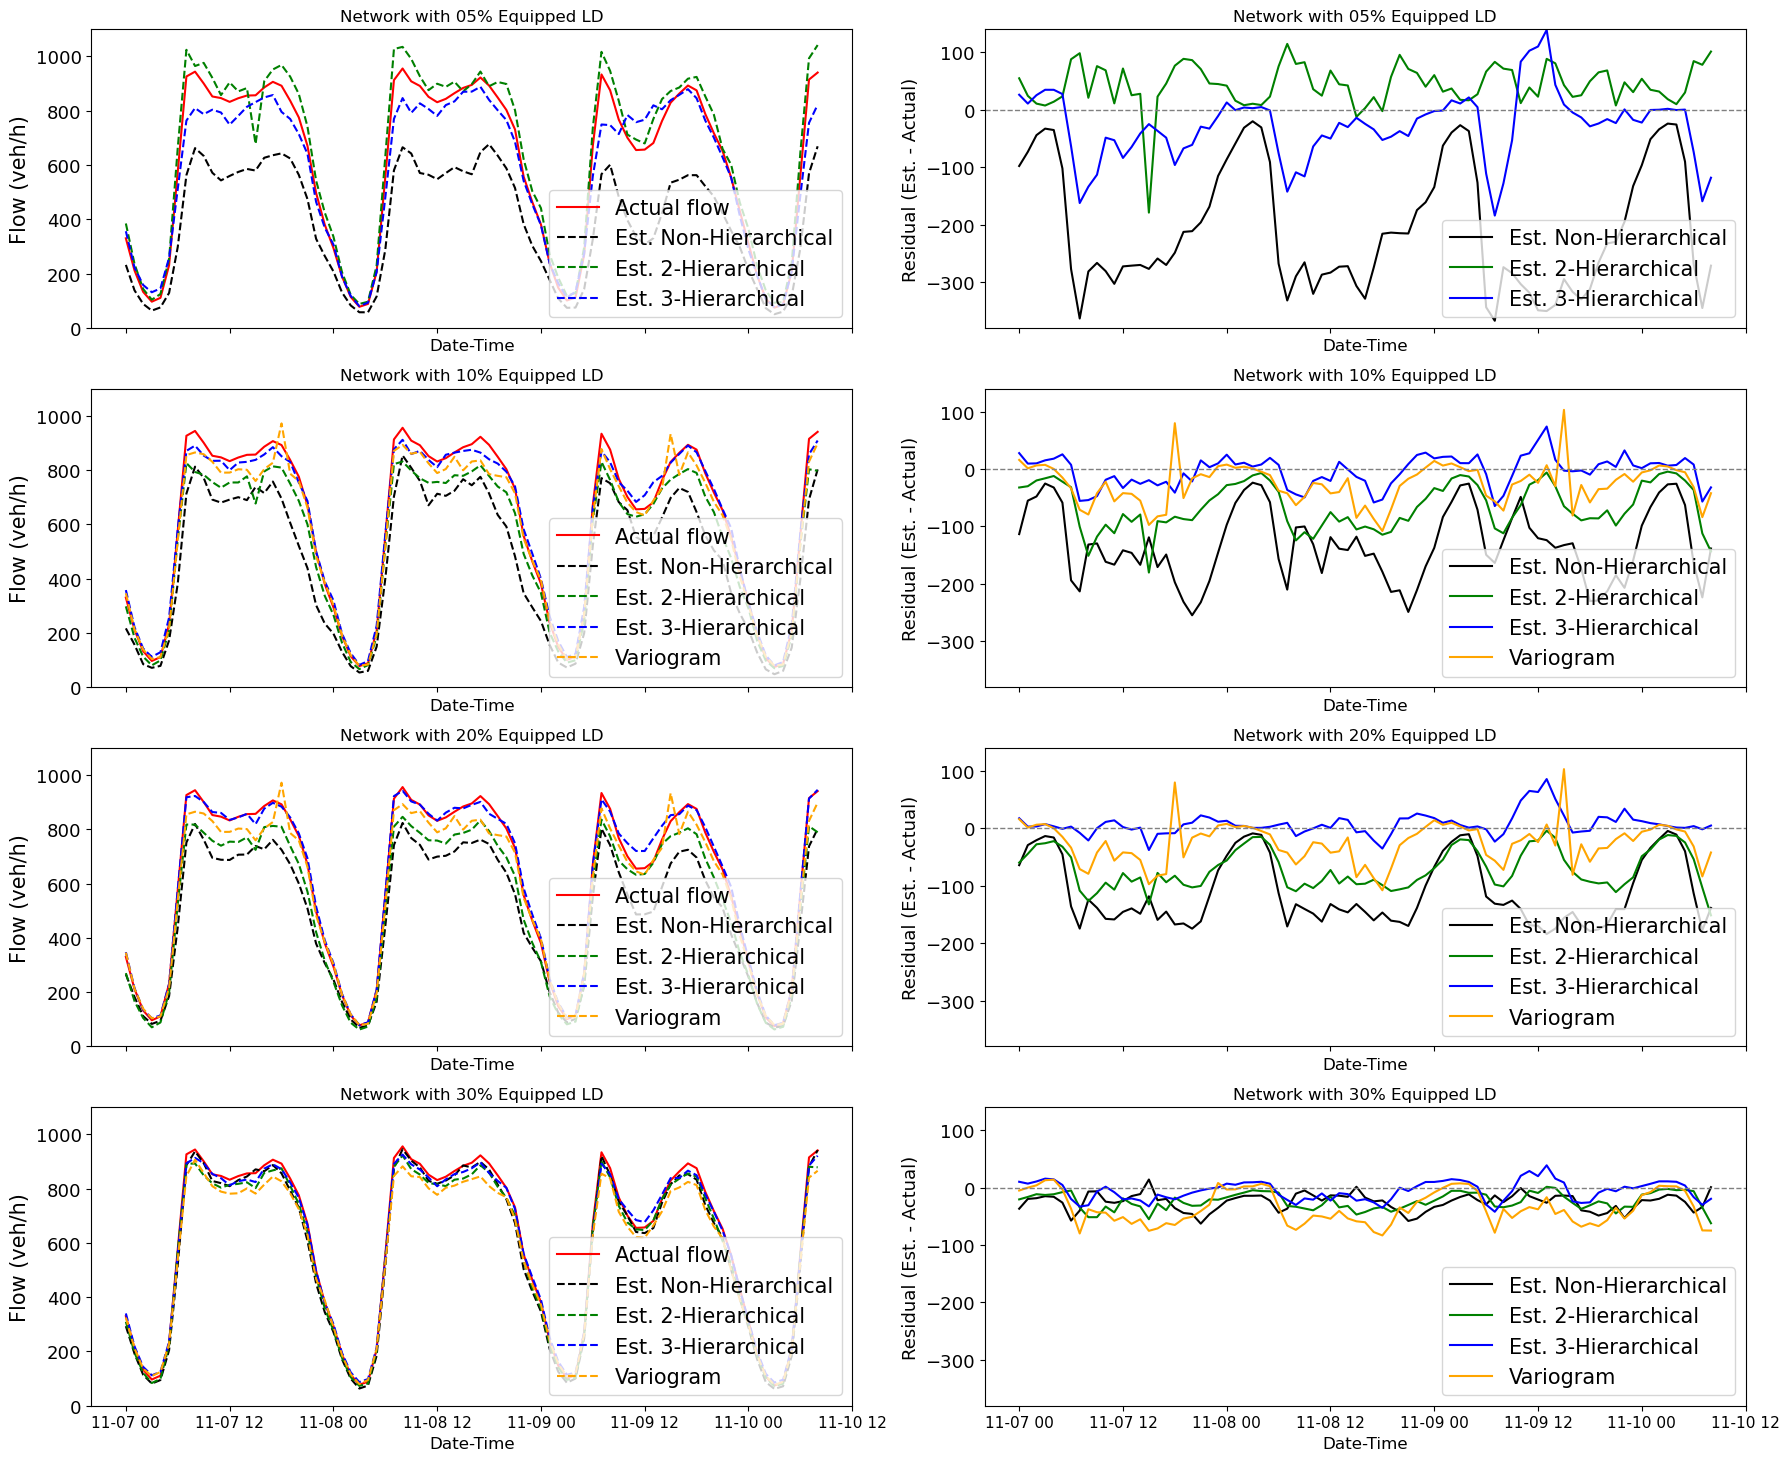

In [8]:

fig, axs = plt.subplots(4, 2, figsize=(18, 16), sharex='col')  # 4 rows, 2 columns: [0] for flow, [1] for residuals

# fig.suptitle('Flow Estimation and Residuals: Estimated vs. Actual Flow at Varying LDD Coverage', fontsize=16)

cutoff_datetime = pd.to_datetime('2022-11-10 08:00:00')

def plot_flow_and_residuals(ax_flow, ax_resid, datetime, actual, est_dict, title):
    datetime = pd.to_datetime(datetime)
    actual = np.array(actual)

    # Filter data up to cutoff datetime
    mask = datetime <= cutoff_datetime
    datetime = datetime[mask]
    actual = actual[mask]

    ax_flow.plot(datetime, actual, 'r-', label='Actual flow')
    
    for label, (est, color) in est_dict.items():
        est = np.array(est)

        # Truncate to the shortest length to prevent mismatch
        min_len = min(len(datetime), len(actual), len(est))
        dt_trimmed = datetime[:min_len]
        actual_trimmed = actual[:min_len]
        est_trimmed = est[:min_len]

        ax_flow.plot(dt_trimmed, est_trimmed, '--', label=label, color=color)
        
        # Plot residuals
        residual = est_trimmed - actual_trimmed
        ax_resid.plot(dt_trimmed, residual, label=f'{label}', linestyle='-', color=color)

    ax_flow.set_title(title)
    ax_flow.set_ylabel('Flow (veh/h)', fontsize=15)
    ax_flow.tick_params(axis='y', labelsize=13)
    ax_flow.legend(fontsize=13)
    ax_flow.set_ylim(0,1100)
    ax_flow.legend(loc='lower right', fontsize=15)
    ax_resid.set_title(title)
    ax_resid.axhline(0, linestyle='--', color='gray', linewidth=1)
    ax_resid.set_ylabel('Residual (Est. - Actual)', fontsize=13)
    ax_resid.tick_params(axis='y', labelsize=13)
    ax_resid.legend(fontsize=13)
    ax_resid.set_ylim(-380,140)
    ax_resid.legend(loc='lower right', fontsize=15)


# Row 1: 05% LDD
plot_flow_and_residuals(
    axs[0, 0], axs[0, 1],
    test_here_05['datetime'],
    test_here_05['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test4['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_05['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_05['net_est_flow'], 'blue')
    },
    'Network with 05% Equipped LD'
)

# Row 2: 10% LDD
plot_flow_and_residuals(
    axs[1, 0], axs[1, 1],
    test_here_10['datetime'],
    test_here_10['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test1['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_10['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_10['net_est_flow'], 'blue'),
        'Variogram': (vario_10_new['mean'], 'orange')
    },
    'Network with 10% Equipped LD'
)

# Row 3: 20% LDD
plot_flow_and_residuals(
    axs[2, 0], axs[2, 1],
    test_here_20['datetime'],
    test_here_20['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test2['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_20['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_20['net_est_flow'], 'blue'),
        'Variogram': (vario_20_new['mean'], 'orange')
    },
    'Network with 20% Equipped LD'
)

# Row 4: 30% LDD
plot_flow_and_residuals(
    axs[3, 0], axs[3, 1],
    test_here_30['datetime'],
    test_here_30['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test3['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_30['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_30['net_est_flow'], 'blue'),
        'Variogram': (vario_30_new['mean'], 'orange')
    },
    'Network with 30% Equipped LD'
)

# Shared labels
for ax in axs[:, 0]:
    ax.set_xlabel('Date-Time', fontsize=12)
    ax.tick_params(axis='x', labelsize=11)
for ax in axs[:, 1]:
    ax.set_xlabel('Date-Time', fontsize=12)
    ax.tick_params(axis='x', labelsize=11)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the title
plt.show()


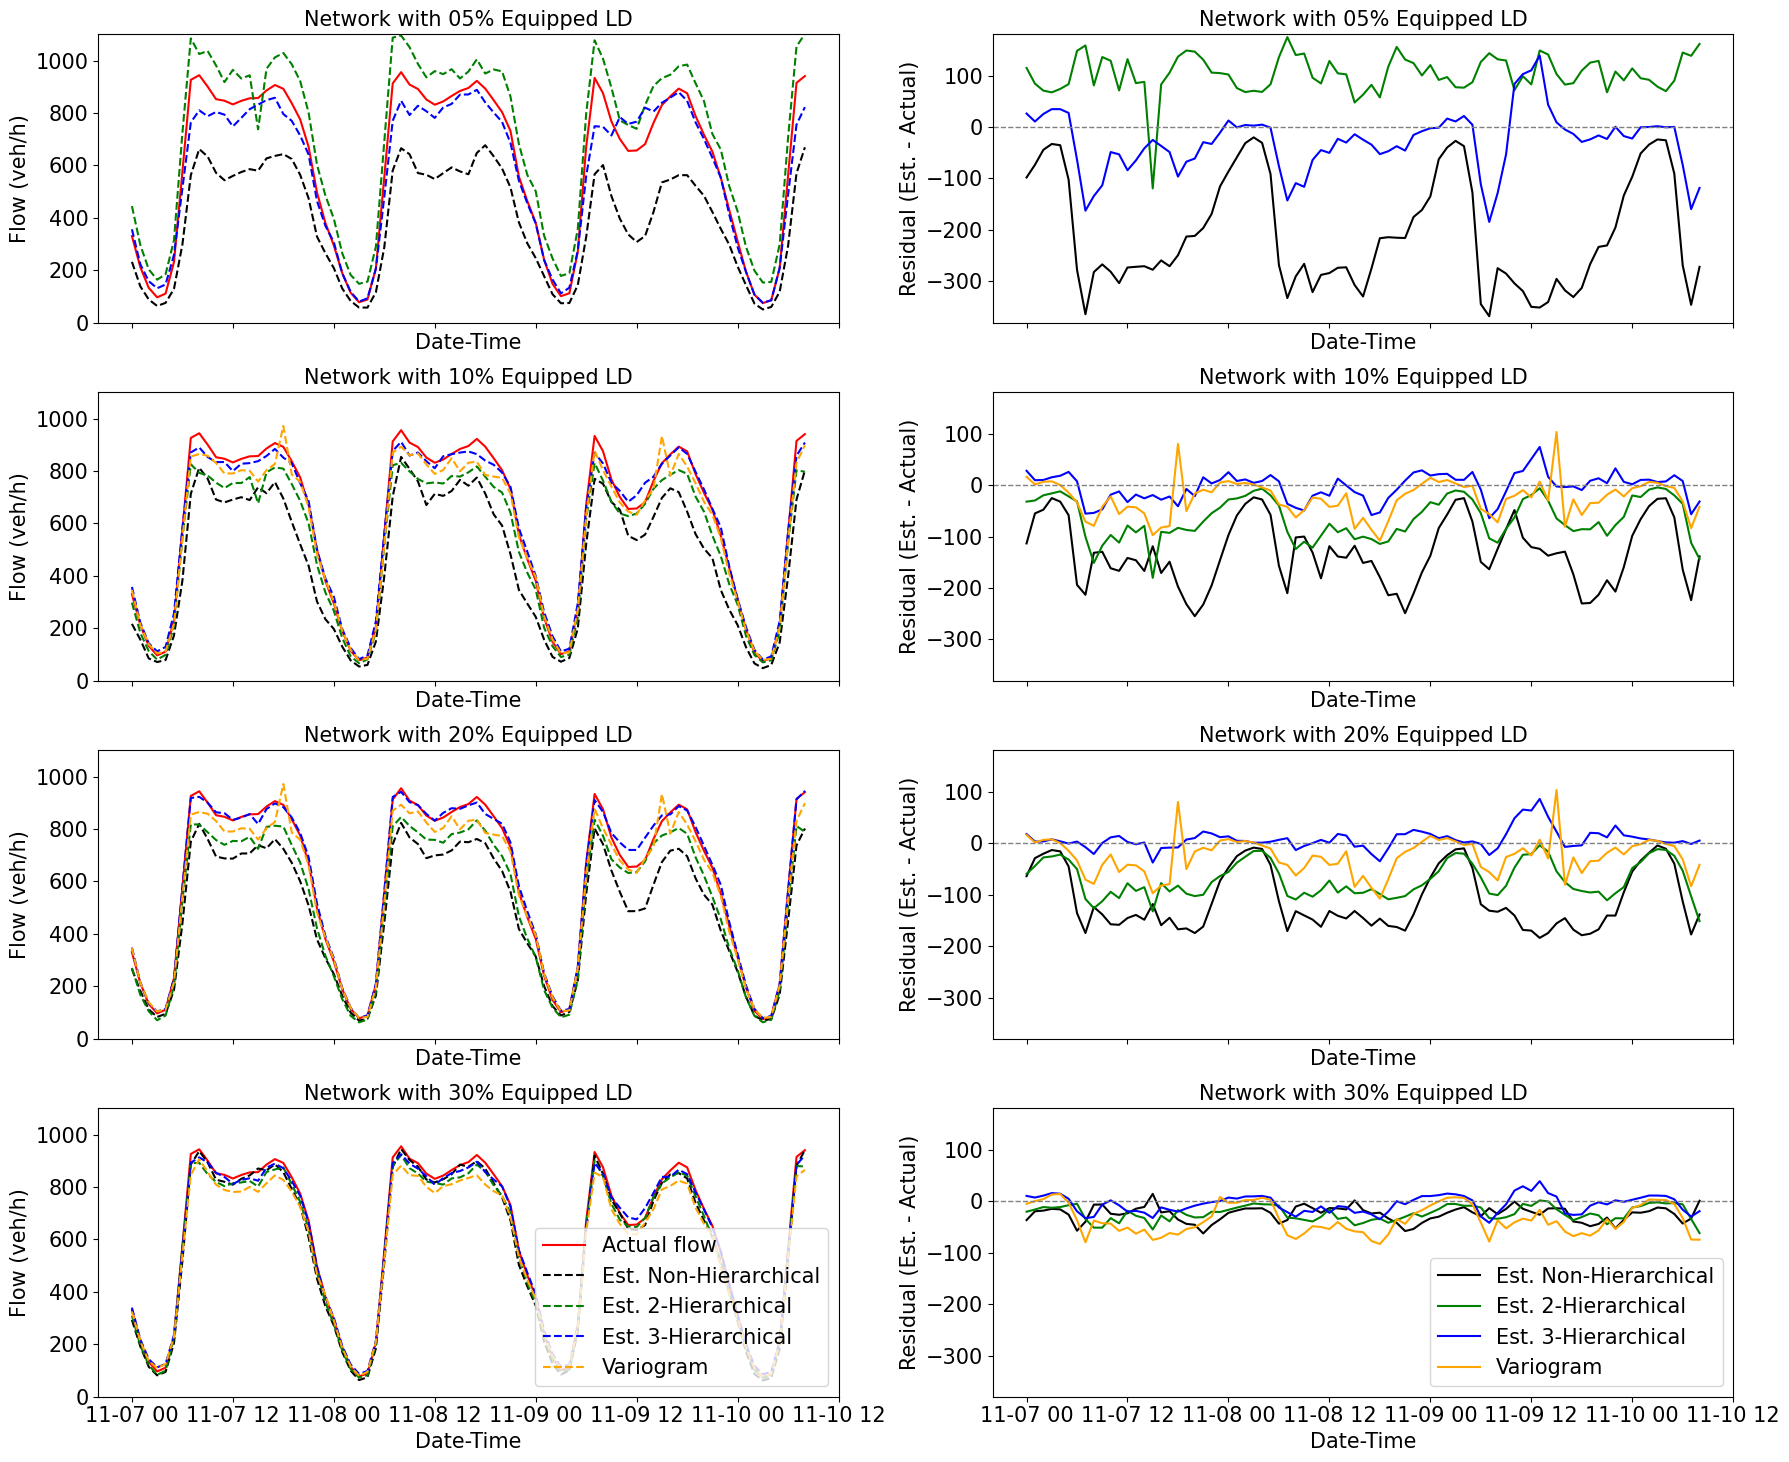

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, axs = plt.subplots(4, 2, figsize=(18, 16), sharex='col')  # 4 rows, 2 columns

cutoff_datetime = pd.to_datetime('2022-11-10 08:00:00')

def plot_flow_and_residuals(ax_flow, ax_resid, datetime, actual, est_dict, title, show_legend=False):
    datetime = pd.to_datetime(datetime)
    actual = np.array(actual)

    # Filter data up to cutoff datetime
    mask = datetime <= cutoff_datetime
    datetime = datetime[mask]
    actual = actual[mask]

    ax_flow.plot(datetime, actual, 'r-', label='Actual flow')

    for label, (est, color) in est_dict.items():
        est = np.array(est)

        # Truncate to the shortest length to prevent mismatch
        min_len = min(len(datetime), len(actual), len(est))
        dt_trimmed = datetime[:min_len]
        actual_trimmed = actual[:min_len]
        est_trimmed = est[:min_len]

        ax_flow.plot(dt_trimmed, est_trimmed, '--', label=label, color=color)

        # Plot residuals
        residual = est_trimmed - actual_trimmed
        ax_resid.plot(dt_trimmed, residual, label=label, linestyle='-', color=color)

    
    ax_flow.set_title(title, fontsize=15)
    ax_flow.set_ylabel('Flow (veh/h)', fontsize=15)
    ax_flow.tick_params(axis='y', labelsize=15)
    ax_flow.set_ylim(0, 1100)

    ax_resid.set_title(title, fontsize=15)
    ax_resid.axhline(0, linestyle='--', color='gray', linewidth=1)
    ax_resid.set_ylabel('Residual (Est. - Actual)', fontsize=15)
    ax_resid.tick_params(axis='y', labelsize=15)
    ax_resid.set_ylim(-380, 180)

    if show_legend:
        ax_flow.legend(loc='lower right', fontsize=15)
        ax_resid.legend(loc='lower right', fontsize=15)


# Row 1: 05% LDD
plot_flow_and_residuals(
    axs[0, 0], axs[0, 1],
    test_here_05['datetime'],
    test_here_05['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test4['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_05['net_est_flow']+60, 'green'),
        'Est. 3-Hierarchical': (test_here_05['net_est_flow'], 'blue')
    },
    'Network with 05% Equipped LD',
    show_legend=False
)

# Row 2: 10% LDD
plot_flow_and_residuals(
    axs[1, 0], axs[1, 1],
    test_here_10['datetime'],
    test_here_10['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test1['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_10['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_10['net_est_flow'], 'blue'),
        'Variogram': (vario_10_new['mean'], 'orange')
    },
    'Network with 10% Equipped LD',
    show_legend=False
)

# Row 3: 20% LDD
plot_flow_and_residuals(
    axs[2, 0], axs[2, 1],
    test_here_20['datetime'],
    test_here_20['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test2['est_fl'], 'black'),
        'Est. 2-Hierarchical': (test_ath_20['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_20['net_est_flow'], 'blue'),
        'Variogram': (vario_20_new['mean'], 'orange')
    },
    'Network with 20% Equipped LD',
    show_legend=False
)

# Row 4: 30% LDD — show legend only here
plot_flow_and_residuals(
    axs[3, 0], axs[3, 1],
    test_here_30['datetime'],
    test_here_30['net_act_flw'],
    {
        'Est. Non-Hierarchical': (test3['est_fl'] - 10, 'black'),
        'Est. 2-Hierarchical': (test_ath_30['net_est_flow'], 'green'),
        'Est. 3-Hierarchical': (test_here_30['net_est_flow'] + 10, 'blue'),
        'Variogram': (vario_30_new['mean'] + 5, 'orange')
    },
    'Network with 30% Equipped LD',
    show_legend=True
)

# Shared X-axis labels
for ax in axs[:, 0]:
    ax.set_xlabel('Date-Time', fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
for ax in axs[:, 1]:
    ax.set_xlabel('Date-Time', fontsize=15)
    ax.tick_params(axis='x', labelsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the title
plt.show()


In [404]:
# Assuming both 'test_here_05' (actual) and 'test4' (estimated) dataframes have a 'datetime' column and respective flow columns
test_here_30['datetime'] = pd.to_datetime(test_here_30['datetime'])
test_ath_05['datetime'] = pd.to_datetime(test_ath_05['datetime'])

# Merge the two dataframes on the 'datetime' column for proper alignment
merged_data = pd.merge(test_here_30[['datetime', 'net_act_flw']], test_ath_05[['datetime', 'net_est_flow']], on='datetime')

# Calculate the squared differences between actual and estimated flow
merged_data['squared_error'] = (merged_data['net_act_flw'] - merged_data['net_est_flow'])**2

# Group by day and calculate RMSE
daily_rmse = merged_data.groupby(merged_data['datetime'].dt.date)['squared_error'].apply(lambda x: np.sqrt(np.mean(x)))

# Display the RMSE for each day
print(daily_rmse)


datetime
2022-11-07    65.970680
2022-11-08    53.567834
2022-11-09    51.083160
2022-11-10    64.064266
2022-11-11    48.374283
Name: squared_error, dtype: float64


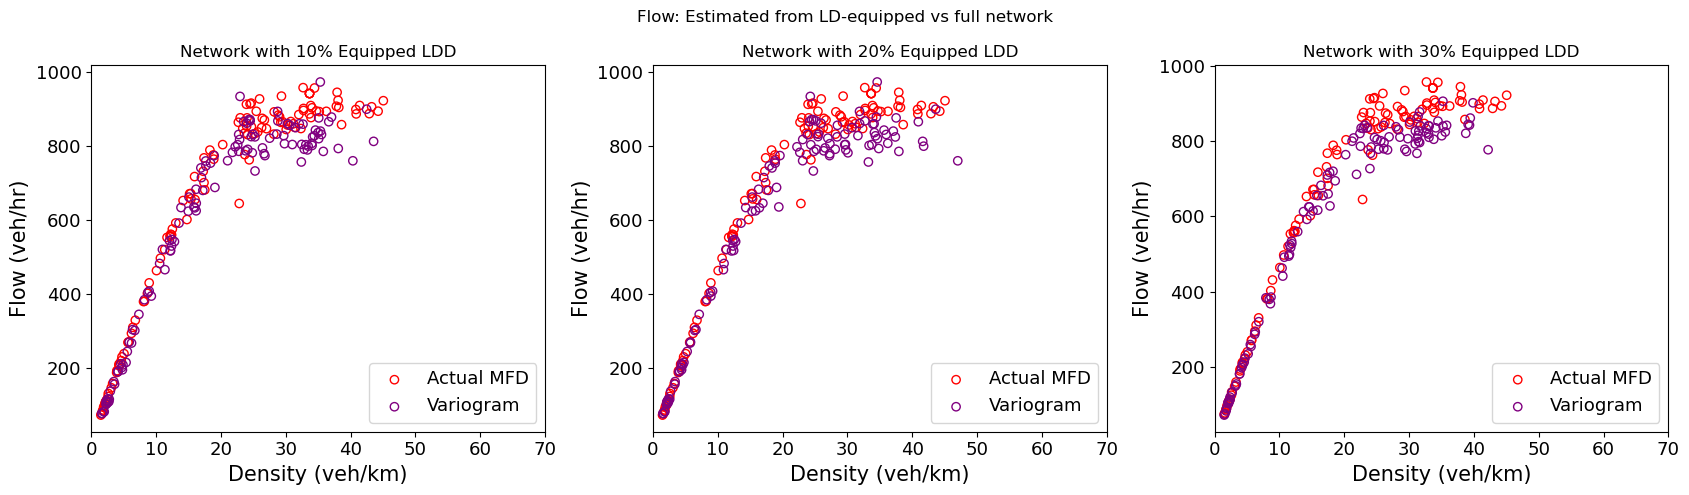

In [296]:

fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(17, 5))  # Adjust figsize as per your needs

fig.suptitle('Flow: Estimated from LD-equipped vs full network')

#ax1.scatter( test_here_05['net_act_den'],test_here_05['net_act_flw'], marker='o',edgecolor='r',facecolors='none', label='Actual MFD')
#ax1.scatter( test4['net_est_den'],test4['est_fl'],  marker='o',edgecolor='black',facecolors='none', label='Non-Hierarchical', alpha=1.0)
#ax1.scatter( test_ath_05['net_est_den'],test_ath_05['net_est_flow'],  marker='o',edgecolor='green',facecolors='none',label='2-Hierarchical', alpha=1.0)
#ax1.scatter( test_here_05['net_est_den'],test_here_05['net_est_flow'],  marker='o',edgecolor='blue',facecolors='none',label='3-Hierarchical', alpha=1.0)
#ax1.scatter( vario_10_new['net_est_den'],vario_10_new['mean'], marker='o',edgecolor='purple',facecolors='none', label='Variogram', alpha=1.0)


ax1.set_title('Network with 05% Equipped LDD') 
ax1.set_ylabel('Flow (veh/hr)',fontsize=15)    
ax1.set_xlabel('Density (veh/km)',fontsize=15)
ax1.set_xlim(0,70)
ax1.tick_params(axis='y', labelsize=13) 
ax1.tick_params(axis='x', labelsize=13)
ax1.legend(fontsize=13)

# Plot for ax1
# ax1.plot(x, y, label='$q_{10\% LDD}=q_{100\% LDD}$', color='Red')
ax2.scatter(test_here_10['net_act_den'],test_here_10['net_act_flw'], marker='o',edgecolor='r',facecolors='none', label='Actual MFD')
#ax2.scatter( test1['net_est_den'],test1['est_fl'], marker='o',edgecolor='black',facecolors='none', label='Non-Hierarchical', alpha=1.0)
#ax2.scatter( test_here_10['net_est_den'],test_here_10['net_est_flow'], marker='o',edgecolor='green',facecolors='none', label='2-Hierarchical', alpha=1.0)
#ax2.scatter( test_ath_10['net_est_den'],test_ath_10['net_est_flow'], marker='o',edgecolor='blue',facecolors='none',label='3-Hierarchical' , alpha=1.0)
ax2.scatter( vario_10_new['net_est_den'],vario_10_new['mean'], marker='o',edgecolor='purple',facecolors='none', label='Variogram', alpha=1.0)

ax2.set_title('Network with 10% Equipped LDD') 
ax2.set_ylabel('Flow (veh/hr)',fontsize=15)    
ax2.set_xlabel('Density (veh/km)',fontsize=15)
ax2.set_xlim(0,70)
ax2.tick_params(axis='y', labelsize=13) 
ax2.tick_params(axis='x', labelsize=13)
ax2.legend(fontsize=13)

# Plot for ax1
# ax2.plot(x, y, label='$q_{20\% LDD}=q_{100\% LDD}$', color='Red')
ax3.scatter( test_here_20['net_act_den'],test_here_20['net_act_flw'], marker='o',edgecolor='r',facecolors='none', label='Actual MFD')
#ax3.scatter( test2['net_est_den'],test2['est_fl'],  marker='o',edgecolor='black',facecolors='none',label='Non-Hierarchical', alpha=1.0)
#ax3.scatter( test_ath_20['net_est_den'],test_ath_20['net_est_flow'], marker='o',edgecolor='green',facecolors='none', label='2-Hierarchical', alpha=1.0)
#ax3.scatter( test_here_20['net_est_den'],test_here_20['net_est_flow'],   marker='o',edgecolor='blue',facecolors='none', label='3-Hierarchical', alpha=1.0)
ax3.scatter( vario_20_new['net_est_den'],vario_20_new['mean'], marker='o',edgecolor='purple',facecolors='none', label='Variogram', alpha=1.0)

ax3.set_xlim(0,70)
ax3.set_title('Network with 20% Equipped LDD') 
ax3.set_ylabel('Flow (veh/hr)',fontsize=15)    
ax3.set_xlabel('Density (veh/km)',fontsize=15)  
ax3.tick_params(axis='y', labelsize=13) 
ax3.tick_params(axis='x', labelsize=13)
ax3.legend(fontsize=13)

# Plot for ax1
ax4.scatter(test_here_30['net_act_den'],test_here_30['net_act_flw'], marker='o',edgecolor='r',facecolors='none', label='Actual MFD')
#ax4.scatter( test3['net_est_den'],test3['est_fl'], marker='o',edgecolor='black',facecolors='none',label='Non-Hierarchical', alpha=1.0)
#ax4.scatter( test_ath_30['net_est_den'],test_ath_30['net_est_flow'], marker='o',edgecolor='green',facecolors='none', label='2-Hierarchical', alpha=1.0)
#ax4.scatter( test_here_30['net_est_den'],test_here_30['net_est_flow'],   marker='o',edgecolor='blue',facecolors='none', label='3-Hierarchical', alpha=1.0)
ax4.scatter( vario_30_new['net_est_den'],vario_30_new['mean'], marker='o',edgecolor='purple',facecolors='none', label='Variogram', alpha=1.0)

ax4.set_xlim(0,70)
ax4.set_title('Network with 30% Equipped LDD') 
ax4.set_ylabel('Flow (veh/hr)',fontsize=15)    
ax4.set_xlabel('Density (veh/km)',fontsize=15)
ax4.tick_params(axis='y', labelsize=13) 
ax4.tick_params(axis='x', labelsize=13)
ax4.legend(fontsize=13)


# Display the plot
plt.tight_layout()
plt.show()